## Problematic GRB
This is the GRB 050128, with 2ms time gap between points.
Works as expected:-

| No of Data Points    | Time Taken |
| -------- | -------   |
|  20      |  2.2 min   |
| 120      |  54 min   |

## Loading Dependencies

In [2]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

## Loading Data:
This code is mainly to pick up the text file of the specified GRB and convert it into a numpy arrays

In [3]:
def truncate_data(times: np.ndarray, counts: np.ndarray, start: float, stop: float, yerr: np.ndarray = None) -> tuple:
    indices = np.where(np.logical_and(times > start, times < stop))[0]
    if yerr is None:
        return times[indices], counts[indices]
    else:
        return times[indices], counts[indices], yerr[indices]

def get_grb_data_from_segment(
        grb_id: str, grb_binning: str, start_time: float, end_time: float, grb_detector: str = None,
        grb_energy_band: str = "all", grb_label: str = None, bin_size: str = None, **kwargs) -> tuple:
    times, y, yerr = get_all_grb_data(grb_binning=grb_binning, grb_id=grb_id, grb_detector=grb_detector,
                                      grb_label=grb_label, grb_energy_band=grb_energy_band, bin_size=bin_size)
    return truncate_data(times=times, counts=y, start=start_time, stop=end_time, yerr=yerr)


def get_all_grb_data(
        grb_id: str, grb_binning: str, grb_detector: str = None, grb_energy_band: str = "all", grb_label: str = None,
        bin_size: str = None, **kwargs) -> tuple:
    if grb_detector in ["swift", "konus"]:
        data_file = f"data/GRBs/GRB{grb_id}/{grb_binning}_lc_ascii_{grb_detector}.txt"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        if grb_detector == "swift":
            if grb_energy_band == "15-25":
                y = data[:, 1]
                yerr = data[:, 2]
            elif grb_energy_band == "25-50":
                y = data[:, 3]
                yerr = data[:, 4]
            elif grb_energy_band == "50-100":
                y = data[:, 5]
                yerr = data[:, 6]
            elif grb_energy_band == "100-350":
                y = data[:, 7]
                yerr = data[:, 8]
            elif grb_energy_band in ["all", "15-350"]:
                y = data[:, 9]
                yerr = data[:, 10]
            else:
                raise ValueError(f"Energy band {grb_energy_band} not understood")
            return times, y, yerr
        elif grb_detector == "konus":
            y = data[:, 1]
            return times, y, np.sqrt(y)
    elif grb_detector == "batse":
        data_file = f"data/GRBs/GRB{grb_id}/GRB{grb_id}_{grb_energy_band}"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        y = data[:, 1]
        yerr = np.sqrt(y)
        return times, y, yerr
    elif grb_detector.lower() == "asim":
        data_file = f"data/GRBs/GRB{grb_id}/{grb_label}.txt"
        ttes = np.loadtxt(data_file)
        y, bin_edges = np.histogram(ttes, np.arange(ttes[0], ttes[-1], bin_size))
        times = np.array([bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2 for i in range(len(bin_edges) - 1)])
        yerr = np.sqrt(y)
        return times, y, yerr
    
_GRB_RUN_MODES = dict(select_time=get_grb_data_from_segment,
                      entire_segment=get_all_grb_data)

def get_grb_data(run_mode: str, **kwargs) -> tuple:
    """ Catch all function """
    return _GRB_RUN_MODES[run_mode](**kwargs)

## Labels for our GRB

In [16]:
grb_id = "070220"
grb_label = ""
grb_binning = "1s"
grb_detector = "swift"
grb_energy_band = "all"

times, y, yerr = get_all_grb_data(
        grb_id = grb_id, grb_binning = grb_binning, grb_detector = grb_detector, 
        grb_energy_band = grb_energy_band, grb_label= grb_label,
        bin_size= None)

In [17]:
print(times.shape, y.shape, yerr.shape)

(1202,) (1202,) (1202,)


#### Plotting the Total Lightcurve
Has a 782 points

<ErrorbarContainer object of 3 artists>

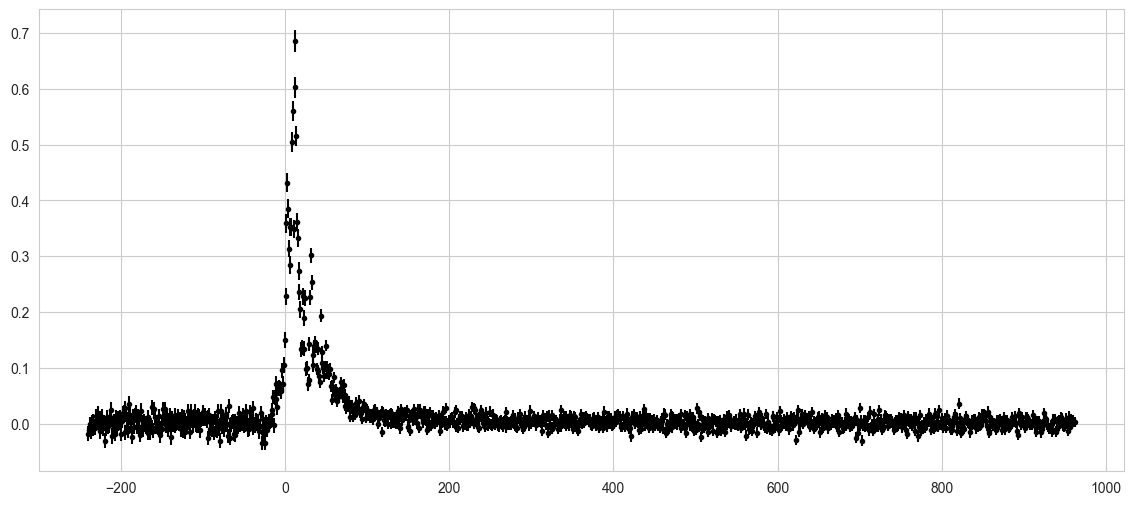

In [18]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(times, y, yerr=yerr, fmt=".k", capsize=0, label="data")

## Slicing the GRB
Here We can slice the data by putting the start and end time that we want to use

**Saved as times2, y2, yerr2**

Example from t = -10.0 to t = +110.0
This will give us a lightcurve of 120 points

In [19]:
times2, y2, yerr2 = get_grb_data_from_segment(
        grb_id = grb_id, grb_binning = grb_binning, start_time = -10.0, end_time = +30, grb_detector = grb_detector,
        grb_energy_band = grb_energy_band, grb_label = grb_label, bin_size= None)
print(times2.shape, y2.shape, yerr2.shape)

(40,) (40,) (40,)


<ErrorbarContainer object of 3 artists>

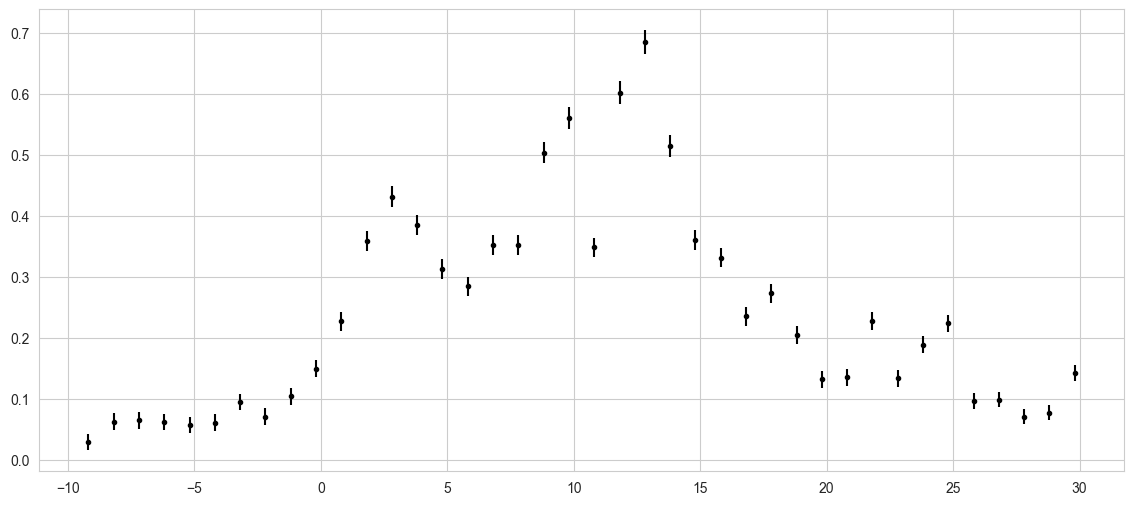

In [20]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(times2, y2, yerr=yerr2, fmt=".k", capsize=0, label="data")

## Posterior Sampling

For sliced data (120 points) using **times2, y2, yerr2**.

Stopped the sampling as it took a lot of time.

In [21]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")
import tensorflow_probability.substrates.jax as tfp
from gpmodelling import get_prior, get_likelihood, get_gp_params, get_kernel, get_mean
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list2 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list2)

['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [22]:
times = times2
counts = y2
params_list = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")

counts2 = y2
total_time = times2[-1] - times2[0]
f = 1/(times2[1]- times2[0])
span = jnp.max(counts2) - jnp.min(counts2)

prior_dict = {
    "A": tfpb.Log()(tfpd.Uniform(low = 0.1 * span , high= 2 * span )),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "sig": tfpb.Log()(tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * total_time )),

    "arn": tfpb.Log()(tfpd.Uniform(low = 0.1 * span , high = 2 * span )),
    "crn": tfpb.Log()(tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f))),
    
    "aqpo": tfpb.Log()(tfpd.Uniform(low = 0.1 * span, high = 2 * span )),
    "cqpo": tfpb.Log()(tfpd.Uniform(low = 1/10/total_time, high = jnp.log(f))),
    "freq": tfpd.Uniform(low = 2 , high = f/4 ),
}

prior_model4 = get_prior(params_list, prior_dict)

# likelihood_model4 = get_likelihood(params_list, kernel_type= "QPO_plus_RN", mean_type = "gaussian", Times = times2, counts = counts2)
def likelihood_model4(arn, crn, aqpo, cqpo, freq, A, t0, sig):
    
    kernel_params = { "arn": jnp.exp(arn), "crn": jnp.exp(crn), "aqpo": jnp.exp(aqpo), "cqpo": jnp.exp(cqpo), "freq": freq}
    mean_params = {"A": jnp.exp(A), "t0": t0, "sig": jnp.exp(sig)}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

In [23]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jax import random

NSmodel = Model(prior_model=prior_model4, log_likelihood=likelihood_model4)
NSmodel.sanity_check(random.PRNGKey(10), S=100)

Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
Termination_reason, State = Exact_ns(
    random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
)
Results = Exact_ns.to_results(State, Termination_reason)
print("Simulation Complete")

INFO[2023-08-17 11:41:22,885]: Sanity check...
INFO[2023-08-17 11:41:22,890]: Sanity check passed


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/tree_util.py(78): tree_unflatten
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/debugging.py(241): _flat_callback
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/debugging.py(87): debug_callback_impl
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/debugging.py(151): _callback
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py(1917): _wrapped_callback
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py(1341): __call__
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/profiler.py(314): wrapper
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/pjit.py(1143): _pjit_call_impl_python
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/pjit.py(1187): call_impl_cache_miss
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/pjit.py(1203): _pjit_call_impl
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/core.py(815): process_primitive
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/core.py(383): bind_with_trace
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/core.py(2677): bind
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/pjit.py(163): _python_pjit_helper
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/pjit.py(250): cache_miss
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jaxns/nested_sampler.py(340): __call__
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/jaxns/nested_sampler.py(407): __call__
  /var/folders/z9/d9jc5k554dl6jd5l6z3_h5f80000gn/T/ipykernel_65797/1828580543.py(8): <module>
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3508): run_code
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3448): run_ast_nodes
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3269): run_cell_async
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3064): _run_cell
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3009): run_cell
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel/zmqshell.py(540): run_cell
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel/ipkernel.py(422): do_execute
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel/kernelbase.py(740): execute_request
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel/kernelbase.py(412): dispatch_shell
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel/kernelbase.py(505): process_one
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel/kernelbase.py(516): dispatch_queue
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/asyncio/events.py(80): _run
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/asyncio/base_events.py(607): run_forever
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/tornado/platform/asyncio.py(195): start
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel/kernelapp.py(728): start
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/traitlets/config/application.py(1043): launch_instance
  /Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
